In [48]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords as sw
from nltk.tokenize import TweetTokenizer
import nltk
import string
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

FEATURE_LIST = ['full_text', 'user', 'retweet_count', 'favorite_count']
N_BINS = 18

stopwords = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'doe', 'ha', "n't", 'sha', 'wa', 'wo']
IMAGE_PATH = 'images/'
SUBMISSIONS_PATH = 'submissions/'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:

class LemmaTokenizer(object):
    def __init__(self, wordcloud=False):
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = TweetTokenizer()
        self.wordcloud = wordcloud

    def __call__(self, document):
        lemmas = []

        for t in self.tokenizer.tokenize(document):
            t.strip()
            lemma = self.lemmatizer.lemmatize(t)

            if self.wordcloud:
                if lemma not in string.punctuation and len(lemma) > 2:
                    lemmas.append(lemma)
            else:
                # remove tokens with only punctuation
                if lemma not in string.punctuation:
                    lemmas.append(lemma)

        return lemmas

class ClfSwitcher(BaseEstimator):

    def __init__(
        self,
        estimator = SGDClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

def generate_wordclouds(X, X_tfidf, k, word_positions):
    """Cluster X with K-means with the specified k, and generate one wordcloud per cluster.

    :input X: numpy.array or numpy.matrix to cluster
    :input X_tfidf: sparse matrix with TFIDF values
    :input k: the k to be used in K-means
    :input word_positions: dictionary with pairs as word index (in vocabulary) -> word
    :return cluster_ids: set with the clusters ids
    """

    model = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    y_pred = model.fit_predict(X)
    cluster_ids = set(y_pred)
    top_count = 100

    for cluster_id in cluster_ids:

        # compute the total tfidf for each term in the cluster
        tfidf = X_tfidf[y_pred == cluster_id]
        tfidf_sum = np.sum(tfidf, axis=0) # numpy.matrix
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1) # numpy.array of shape (1, X.shape[1])
        top_indices = tfidf_sum.argsort()[-top_count:]

        term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="black")
        wordcloud = wc.generate_from_frequencies(term_weights)

        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {cluster_id}")
        plt.savefig(IMAGE_PATH + 'wordcloud' + str(cluster_id))

    return cluster_ids

def preprocess_users(users, feature):
    feature_values = [item[feature] for item in users]

    return feature_values

def preprocess_desc(users, tweets):
    desc_list = [item['description'] for item in users] # obtain list of descriptions
    tweets = tweets.tolist()
    joined = [' '.join(z) for z in zip(tweets, desc_list)]

    return joined

def preprocess_len(df):
    tweets = df.tolist()
    tweets_len = [len(t) for t in tweets] # build a list of tweet lengths
    tweets_len = np.array(tweets_len).reshape(-1,1)

    return tweets_len

In [10]:
training_set = pd.read_json('development.jsonl', lines=True)
test_set = pd.read_json('evaluation.jsonl', lines=True)

X_train = training_set[FEATURE_LIST]
y_train = training_set['class']
X_train["tweet_len"] = preprocess_len(X_train["full_text"])
training_set["tweet_len"] = X_train["tweet_len"]
X_train["followers_count"] = preprocess_users(X_train["user"], "followers_count")
X_train["friends_count"] = preprocess_users(X_train["user"], "friends_count")
X_train["joined"] = preprocess_desc(X_train["user"], X_train["full_text"])

c:\users\david\pycharmprojects\data-science-lab\lab4\venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\david\pycharmprojects\data-science-lab\lab4\venv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\david\pycharmprojects\data-science-lab\lab4\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [8]:
n_positive = training_set.loc[training_set['class'] == 1, 'class'].count()
n_negative = training_set.loc[training_set['class'] == 0, 'class'].count()

n_null_coord = training_set['coordinates'].isna().sum()
n_null_place = training_set['place'].isna().sum()

# number of tweets with 0 as 'favorite_count'
n_pos_favcount = training_set.loc[(training_set['class'] == 0) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100
n_neg_favcount = training_set.loc[(training_set['class'] == 1) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100

median_neg_retweet = training_set.loc[training_set['class'] == 0, 'retweet_count'].median()
median_pos_retweet = training_set.loc[training_set['class'] == 1, 'retweet_count'].median()

median_neg_favcount = training_set.loc[training_set['class'] == 0, 'favorite_count'].median()
median_pos_favcount = training_set.loc[training_set['class'] == 1, 'favorite_count'].median()

tweet_len = [len(tweet) for tweet in training_set['full_text']]
training_set['tweet_len'] = tweet_len

median_pos_len = training_set.loc[training_set['class'] == 1, 'tweet_len'].median()
median_neg_len = training_set.loc[training_set['class'] == 0, 'tweet_len'].median()

max_len_tweet = training_set.full_text.str.len().max()
min_len_tweet = training_set.full_text.str.len().min()

print("Number of positive  tweets: {} ({:.2f}%), number of negative tweets: {} ({:.2f}%)".format(n_positive, n_positive / len(training_set) * 100, n_negative,  n_negative / len(training_set) * 100,))
print("Percentage of null coordinates: {:.2f}%, percentage of null places: {:.2f}%".format(n_null_coord / len(training_set) * 100, n_null_place / len(training_set) * 100))
print("Percentage of tweets with 0 as 'favorite_count': {:.2f}% ({:.2f}% positive tweets - median at {:.2f}, {:.2f}% negative tweets - median at {:.2f})".format(n_pos_favcount + n_neg_favcount, n_pos_favcount, median_pos_favcount, n_neg_favcount, median_neg_favcount))
print("Median of positive retweet count: {:.0f}, median of negative retweet count: {:.0f}".format(median_pos_retweet, median_neg_retweet))
print("Median lenght of positive tweets: {:.0f}, median lenght of negative tweets: {:.0f}".format(median_pos_len, median_neg_len))
print("Longest tweet: {:d} chars, shortest tweet: {:d} chars".format(max_len_tweet, min_len_tweet))

Number of positive  tweets: 39931 (49.91%), number of negative tweets: 40069 (50.09%)
Percentage of null coordinates: 99.85%, percentage of null places: 99.09%
Percentage of tweets with 0 as 'favorite_count': 86.83% (43.87% positive tweets - median at 0.00, 42.96% negative tweets - median at 0.00)
Median of positive retweet count: 137, median of negative retweet count: 928
Median lenght of positive tweets: 140, median lenght of negative tweets: 124
Longest tweet: 921 chars, shortest tweet: 5 chars


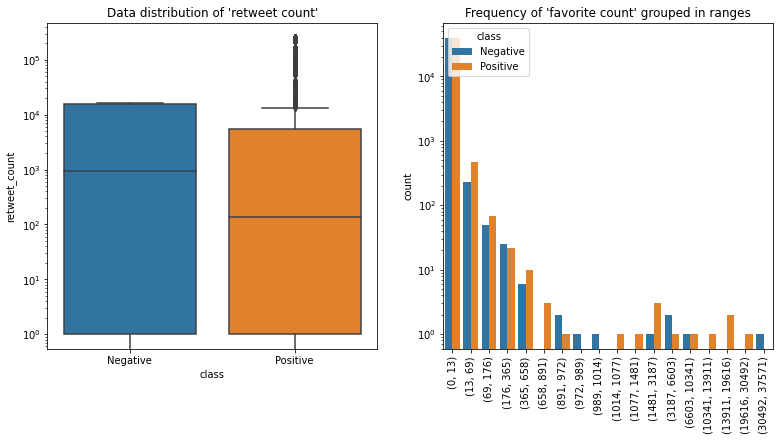

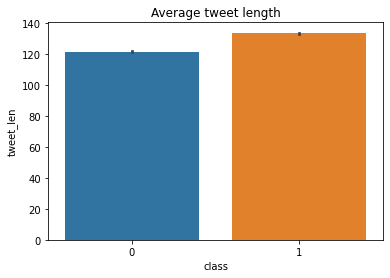

<Figure size 432x288 with 0 Axes>

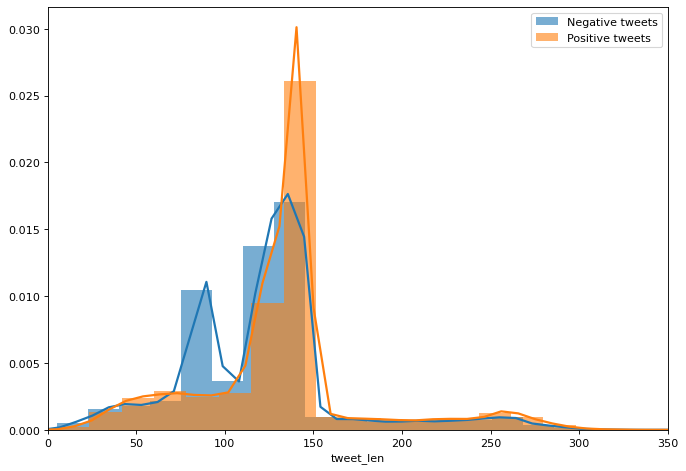

Total variance explained: 0.64


c:\users\david\pycharmprojects\data-science-lab\lab4\venv\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


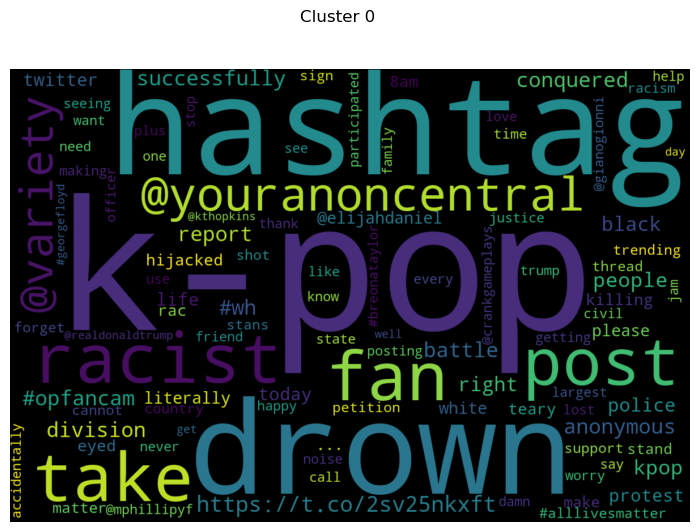

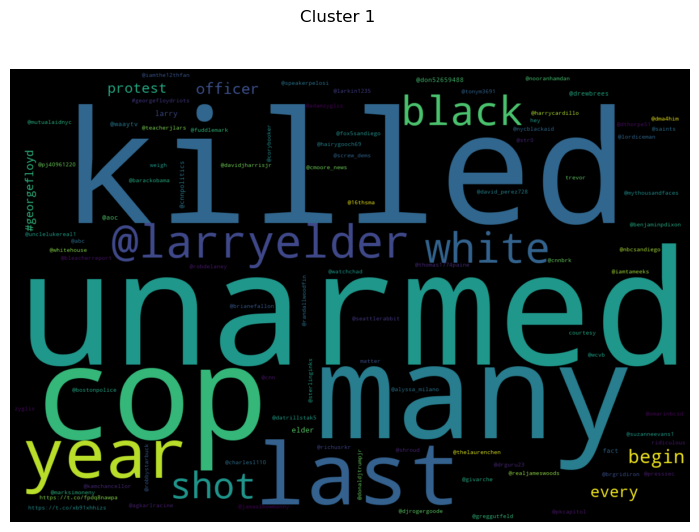

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 6))
g = sns.boxplot('class', 'retweet_count', data=training_set, ax=axs[0])
g.set_yscale('log')
g.set(xticklabels=['Negative', 'Positive'])
axs[0].set_title("Data distribution of 'retweet count'")

fav_count = training_set['favorite_count'].to_numpy().reshape(-1,1)

discretizer = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='kmeans')
X_binned = discretizer.fit_transform(fav_count)
X_binned = np.reshape(X_binned, len(X_binned))

ranges = []
for i in range(len(discretizer.bin_edges_[0]) - 1):
    item = (int(discretizer.bin_edges_[0][i]), int(discretizer.bin_edges_[0][i+1]))
    ranges.append(item)

g = sns.countplot(X_binned, hue='class', data=training_set, ax=axs[1])
g.set_yscale('log')
g.set_xticklabels(ranges, rotation=90)
# replace labels
new_labels = ['Negative', 'Positive']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
axs[1].set_title("Frequency of 'favorite count' grouped in ranges")

plt.savefig(IMAGE_PATH + 'distribution')
plt.show()

ax = plt.subplot()
ax.set_title("Average tweet length")
sns.barplot('class', 'tweet_len', data=training_set)
plt.show()
plt.savefig(IMAGE_PATH + "tweet_len")

x1 = training_set.loc[training_set['class'] == 1, 'tweet_len']
x2 = training_set.loc[training_set['class'] == 0, 'tweet_len']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2}, norm_hist=True)

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(x2, label="Negative tweets", **kwargs)
sns.distplot(x1, label="Positive tweets", **kwargs)

plt.xlim(0,350)
plt.legend()
plt.savefig(IMAGE_PATH + 'len_distrib')
plt.show()

tokenizer = LemmaTokenizer(wordcloud=True)
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords)
X_tfidf = vectorizer.fit_transform(training_set['full_text'])
#vectorizer.get_feature_names()

svd = TruncatedSVD(n_components=700, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")


word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)

In [32]:
tweet_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), binary=True, ngram_range=(1,4))),
])

ordinal_transformer = Pipeline(steps=[
    ('discretize', KBinsDiscretizer(encode='ordinal', strategy='kmeans'))
])

len_transformer = Pipeline(steps=[
    ('preprocess', FunctionTransformer(preprocess_len)),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'))
])

preprocessor = ColumnTransformer(transformers=[
    ('tweet', tweet_transformer, "joined"),
    ('ord', ordinal_transformer, ["retweet_count"]),
], )

preprocessor_features = ColumnTransformer(transformers=[
    ('len', len_transformer, "full_text"),
    ('ord', ordinal_transformer, ["retweet_count", "friends_count", "followers_count", "favorite_count"]),
], )

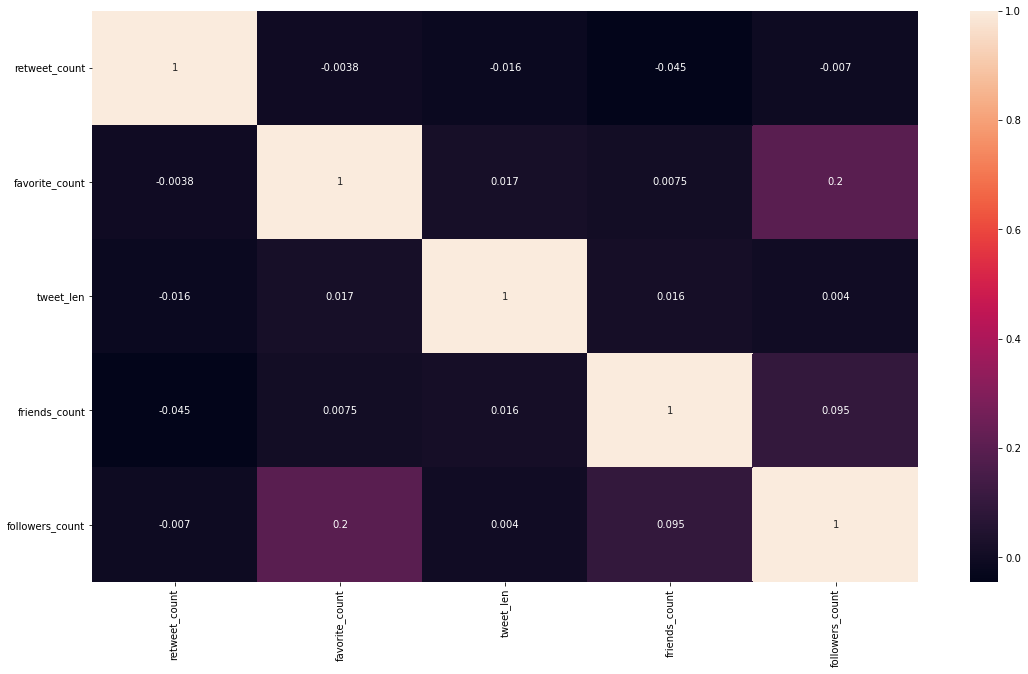

In [22]:
X = X_train[['retweet_count', 'favorite_count', 'tweet_len', 'friends_count', 'followers_count']]
corrMatrix = X.corr()

sns.heatmap(corrMatrix, annot=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig(IMAGE_PATH + 'corr', dpi=80)
plt.show()

          Features        Score
0    retweet_count  2949.058350
2        tweet_len  1133.815061
3    friends_count   414.274299
1   favorite_count     0.731824
4  followers_count     0.116059


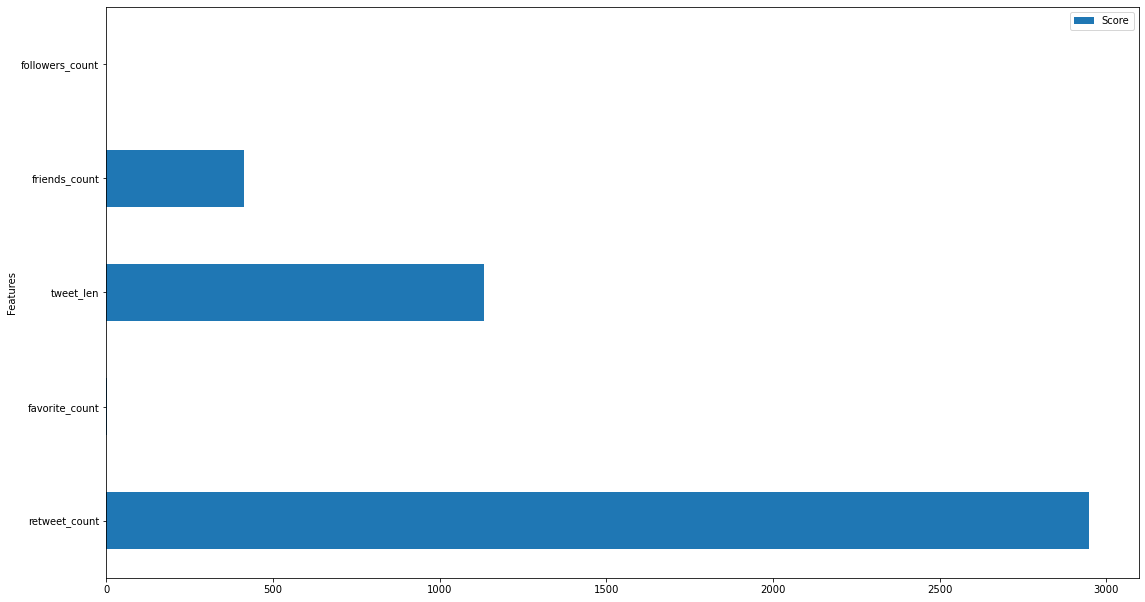

In [29]:

p = Pipeline([
    ('preprocessor', preprocessor_features),
    ('select', SelectKBest(k=5, score_func=chi2))
])

bestfeatures = SelectKBest(k=5)
fit = bestfeatures.fit(X,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))

ax = featureScores.plot.barh(x='Features', y='Score')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig(IMAGE_PATH + 'anova', dpi=80)
plt.show()

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.9min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  5.3min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  9.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 35.5min finished


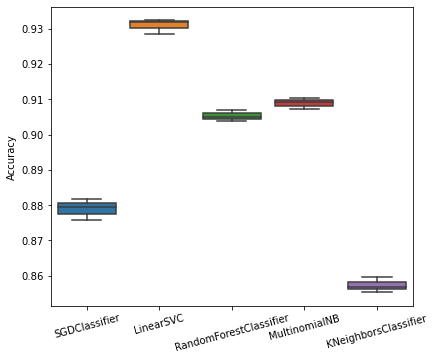

In [30]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', ClfSwitcher()),
])

parameters = [

    {
        'clf__estimator': [SGDClassifier()],
    },
    {
        'clf__estimator': [LinearSVC()],
    },
    {
        'clf__estimator': [RandomForestClassifier()],
    },
    {
        'clf__estimator': [MultinomialNB()],
    },
    {
        'clf__estimator': [KNeighborsClassifier()],
    },
]

gscv = GridSearchCV(pipeline, parameters, cv=15, n_jobs=-1, return_train_score=False, verbose=5)
gscv.fit(X_train, y_train)


A = gscv.cv_results_['split0_test_score']
B = gscv.cv_results_['split1_test_score']
C = gscv.cv_results_['split2_test_score']
D = gscv.cv_results_['split3_test_score']
E = gscv.cv_results_['split4_test_score']
F = gscv.cv_results_['split5_test_score']
G = gscv.cv_results_['split6_test_score']
H = gscv.cv_results_['split7_test_score']
I = gscv.cv_results_['split8_test_score']
J = gscv.cv_results_['split9_test_score']
K = gscv.cv_results_['split10_test_score']
L = gscv.cv_results_['split11_test_score']
M = gscv.cv_results_['split12_test_score']
N = gscv.cv_results_['split13_test_score']
O = gscv.cv_results_['split14_test_score']

classifiers = ['SGDClassifier', 'LinearSVC', 'RandomForestClassifier', 'MultinomialNB', 'KNeighborsClassifier']

clf_dict = {}
for a,b,c,d,e,f,g,h,i,j,k,l,m,n,o, clf in zip(A,B,C,D,E,F,G,H,I,J,K,L,M,N,O, classifiers):
    clf_dict[clf] = [a, b, c, d, e, f, g, h, i, j, k ,l, m, n, o]

df = pd.DataFrame.from_dict(clf_dict)

graph = sns.boxplot(data=df, showfliers=False)
graph.set_ylabel('Accuracy')
graph.set_xticklabels(df.columns, rotation=15)
graph.figure.set_size_inches(6.5, 5.5)
plt.show()

In [34]:
param = [
    {
        'clf__estimator': [SGDClassifier(random_state=42, verbose=3)],
        'clf__estimator__tol': [1e-2, 1e-3, 1e-4, 1e-5],
        'clf__estimator__alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
        'clf__estimator__loss': ('hinge', 'squared_hinge', 'modified_huber'),
        'clf__estimator__penalty' : ['l1', 'l2'],
        'preprocessor__tweet__tfidf__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)],
        'preprocessor__ord__discretize__n_bins':[2,3,4,5,6],
    },
    ]

gscv = GridSearchCV(pipeline, param, cv=3, n_jobs=-1, return_train_score=False, verbose=5)
gscv.fit(X_train, y_train)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
X_test = test_set[FEATURE_LIST]
X_test["tweet_len"] = preprocess_len(X_test["full_text"])
X_test["followers_count"] = preprocess_users(X_test["user"], "followers_count")
X_test["friends_count"] = preprocess_users(X_test["user"], "friends_count")
X_test["joined"] = preprocess_desc(X_test["user"], X_test["full_text"])

predictions = gscv.predict(X_test)
pred = pd.DataFrame()
pred.insert(0, "Predicted", predictions, True)

pred.to_csv(SUBMISSIONS_PATH + 'submission.csv',sep=',', index_label='Id')